In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [5]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = cad_jpy_df.Price.pct_change() * 100
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901


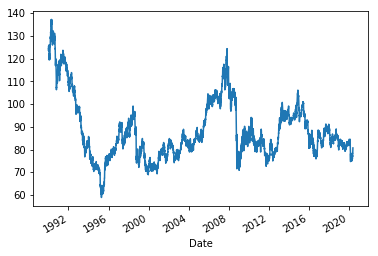

In [6]:
cad_jpy_df.Price.plot()

### Lagged Returns 

In [7]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return'] = cad_jpy_df.Return.shift()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


### Train Test Split

In [8]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [9]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [10]:
# Preview the X_train data
X_train.head()

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


In [11]:
# Display top rows for y_train
y_train.head()

Date
1990-01-04   -1.468476
1990-01-05    0.874777
1990-01-08   -0.216798
1990-01-09    0.667901
1990-01-10    0.567546
Name: Return, dtype: float64

# Linear Regression Model

In [12]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [13]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)
predictions

array([ 5.43439180e-03, -7.31683532e-03,  3.40452844e-04, -1.35792610e-03,
       -1.63655340e-02, -2.44367146e-02,  1.15651714e-03,  1.73492439e-02,
        4.33531968e-02, -2.79188355e-03, -8.79669862e-03,  4.62791859e-03,
        2.06877900e-03, -1.88146406e-02, -1.64302023e-03,  2.10835730e-02,
       -1.39707968e-02,  7.47924365e-03,  1.03690828e-02,  1.22438303e-03,
        3.63516057e-04, -1.07473155e-03,  2.37901706e-03, -1.49085240e-02,
       -1.59802126e-02,  1.54536828e-02,  4.45325041e-02, -2.15202592e-02,
        2.03666349e-02,  1.93801985e-02, -7.55558060e-03,  1.56978180e-03,
        2.18682555e-02, -2.55883242e-03,  1.76140270e-02,  1.02813536e-02,
       -6.77825725e-03, -1.07473155e-03, -4.75704639e-04,  2.31915773e-02,
       -1.92230440e-02,  7.93509179e-03,  8.26853966e-03,  2.55459614e-02,
        1.08479501e-02,  1.85829065e-02,  4.80661690e-03, -1.65878612e-02,
        6.94315856e-03, -7.26185707e-03, -3.19352362e-02,  1.41704170e-02,
        1.91702958e-02,  

In [14]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [15]:
# Plot the first 20 predictions vs the true values
Results.head(20)

,Return,Predicted Return
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366
2018-01-08,-0.087787,-0.024437
2018-01-09,-0.724876,0.001157
2018-01-10,-1.747981,0.017349
2018-01-11,0.067560,0.043353


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [16]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [17]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.841994632894117


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** Out-of-sample data seem to indicate a better fit with a lower RMSE compared to in-sample data.